In [27]:
# create PyTorch dataset for the training data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision
import torch
from collections import defaultdict

from pycocotools.coco import COCO

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from coco_dataloader import CocoDetection
import random

import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [3]:
# change to gpu 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
# define training and annotation paths
# CHANGE WHEN PUT INTO RUN
TRAIN_PATH = "../../teams/DSC180A_FA20_A00/a01group09/COCO-2017/train2017"
VAL_PATH = "../../teams/DSC180A_FA20_A00/a01group09/COCO-2017/val2017"
JSON_TRAIN_PATH = "../../teams/DSC180A_FA20_A00/a01group09/COCO-2017/anno2017/instances_train2017.json"
JSON_VAL_PATH = "../../teams/DSC180A_FA20_A00/a01group09/COCO-2017/anno2017/instances_val2017.json"

In [6]:
# init coco
coco = COCO(JSON_TRAIN_PATH)

loading annotations into memory...
Done (t=15.83s)
creating index...
index created!


In [7]:
# transformation for image data
transform = transforms.Compose([ 
        transforms.Resize([240,240]),
        transforms.ToTensor()
])

In [8]:
# load coco data
coco_train = CocoDetection(root = TRAIN_PATH, annFile = JSON_TRAIN_PATH, transform = transform )

loading annotations into memory...
Done (t=15.83s)
creating index...
index created!


In [9]:
coco_test =  CocoDetection(root = VAL_PATH, annFile = JSON_VAL_PATH, transform = transform )

loading annotations into memory...
Done (t=3.60s)
creating index...
index created!


In [10]:
valloader = torch.utils.data.DataLoader(coco_train, batch_size=5,
                                       shuffle=True, num_workers=2)

In [11]:
testloader = torch.utils.data.DataLoader(coco_test, batch_size=5,
                                       shuffle=True, num_workers=2)

In [12]:
# get category names 
cats = coco.loadCats(coco.getCatIds())
category_dict = defaultdict(str)
for i in cats:
    category_dict[i['id']] = i['name']
classes = [cat['name'] for cat in cats]

In [20]:
# because the NNCrossEntropy function needs to be index by class from [0,n),
# we need to rescale out features sequentially from 0 to 79
new_category_dict = defaultdict(str)
decoder_category_dict = defaultdict(str) # decode from numbers

In [24]:
counter = 0
for j in [i[0] for i in category_dict.items()]:
    new_category_dict[counter] = j
    decoder_category_dict[counter] = category_dict[j]
    counter += 1

In [25]:
# encoder dict
new_category_dict = dict([(value, key) for key, value in new_category_dict.items()])

In [15]:
# CNN architecture taken from https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 3 channel image means first input is 3, then change output to 6, batch size 5
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2) # scales tensor
        self.conv2 = nn.Conv2d(6, 16, 5) 
        self.fc1 = nn.Linear(51984, 920) # input for matmult, output to decrease dimensionality
        self.fc2 = nn.Linear(920, 170)
        self.fc3 = nn.Linear(170, 80) # output must end in class number aka 80

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
            
        return num_features

net = Net()
net = net.to(device)

In [16]:
# loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [26]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(valloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device) # enable cuda processing

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 5000 == 4999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  5000] loss: 8.287
[1, 10000] loss: 8.044
[1, 15000] loss: 7.724
[1, 20000] loss: 7.370
[2,  5000] loss: 6.813
[2, 10000] loss: 6.648
[2, 15000] loss: 6.568
[2, 20000] loss: 6.418
Finished Training


In [17]:
PATH = "./checkpoint2_model.pth" # model path

In [27]:
torch.save(net.state_dict(), PATH) # save model

In [19]:
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [62]:
# let's test our data
dataiter = iter(testloader)
images, labels = dataiter.next()

In [63]:
images = images.to(device)
outputs = net(images)

In [64]:
_, predicted = torch.max(outputs, 1)
predicted

tensor([0, 0, 0, 0, 0], device='cuda:0')

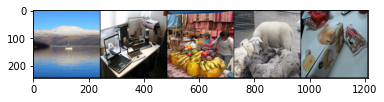

In [65]:
plt.imshow(torchvision.utils.make_grid(torch.Tensor.cpu(images)).permute(1,2,0))
plt.show()

In [61]:
print('Predicted: ', ' '.join([decoder_category_dict[predicted[j].item()] for j in range(5)]))

Predicted:  person person person person person


In [52]:
# accuracy test
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 2500 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 37 %
